Original model with learn rate scheduler

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd

import joblib

import os
import re


In [ ]:
import datetime
date = datetime.date.today()

In [ ]:
# !!!! DON'T RUN AGAIN !!!!

# Clean the coordinate file (Remove unwanted spaces and characters)

import os
import tempfile

def filter_coordinates(input_file_path):
    # Create a temporary file for writing the filtered data
    with tempfile.NamedTemporaryFile(delete=False, mode='w', newline='', dir=os.path.dirname(input_file_path)) as temp_file:
        temp_file_path = temp_file.name
        
        with open(input_file_path, 'r') as infile, open(temp_file_path, 'w') as outfile:
            lines = infile.readlines()
            # print("lines:", lines)
            # Discard the first two lines
            for line in lines[5:]:
                # print("line:", line)
                parts = line.split()
                # print("Parts:", parts)
                if len(parts) == 2:
                    try:
                        x = float(parts[0])
                        y = float(parts[1])
                        # Write the valid line to the temporary file
                        outfile.write(f"{x} {y}\n")
                    except ValueError:
                        # Skip lines where conversion to float fails
                        continue

    # Replace the original file with the filtered data
    os.replace(temp_file_path, input_file_path)

# Directory where files are saved
# save_directory = "airfoil_coordinate_database"
save_directory = "small_database_training_csv"

# Process each file in the directory
for filename in os.listdir(save_directory):
    if filename.endswith("_coordinates.dat"):
        input_path = os.path.join(save_directory, filename)
        filter_coordinates(input_path)

print("Coordinate files cleaned.")

In [3]:
# Downsampling using average pooling
"""
Downsample the input array to 35 elements using interpolation.
"""

def downsample_to_35(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    
    # Reshape the input to be 1D (if it's not already)
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, original_length)
    elif input_tensor.dim() == 2:
        input_tensor = input_tensor.unsqueeze(0)  # Shape (1, original_channels, original_length)
    
    # Perform interpolation to downsample to 35 elements
    downsampled_tensor = F.interpolate(input_tensor, size=35, mode='linear', align_corners=True)
    
    # Remove the unnecessary dimensions to return a 1D tensor
    downsampled_array = downsampled_tensor.squeeze().numpy()
    
    return downsampled_array

In [4]:

def prep_data(root, keyword=None):

    # Initialization of arrays
    # Coordinates
    x_i = [] # Initial coordinates - before downsizing
    y_i = []

    # Polars
    alphas = []
    Cls = []
    Cds = []
    Cms = []

    if keyword:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f == (keyword+'_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f == ('xf-'+keyword+'-il-1000000.csv')]
    else:
        # lists of files in each dir
        coord_files = [f for f in os.listdir(root) if f.endswith('_coordinates.dat')]
        polar_files = [f for f in os.listdir(root) if f.endswith('.csv')]

    # Extract base names from coordinate files
    coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}
    polar_bases = {}
    for polar_file in polar_files:
        match = re.match(r'xf-(.*)-il-1000000\.csv$', polar_file)
        if match:
            base_name = match.group(1)
            polar_bases[base_name] = polar_file
    # print(polar_bases)
    for base_name in coord_bases:
        if base_name in polar_bases:
            coord_file = f"{base_name}_coordinates.dat"
            polar_file = polar_bases[base_name]

            coordinate_data = np.loadtxt(root+coord_file)
            # polar_data = np.loadtxt(root+polar_file, skiprows=12)
            polar_data = pd.read_csv(root+polar_file, skiprows=10)
            polar_data = polar_data[(polar_data['Alpha'] >= -2) & (polar_data['Alpha'] <= 10)]
            # print(len(polar_data))

            # Coordinates
            x = []
            y = []

            # Polars
            alpha = polar_data['Alpha'].values
            Cl = polar_data['Cl'].values
            Cd = polar_data['Cd'].values
            Cm = polar_data['Cm'].values

            # print(alpha)

            for i in range(0, len(coordinate_data)):
                np.array(x.append(float(coordinate_data[i][0]))) 
                np.array(y.append(float(coordinate_data[i][1])))
                
            if len(x) >= 35:    # Only consider the files with more than 35 coordinates
                x_i.append(x)
                y_i.append(y)

                alphas.append(alpha)
                # Cls.append(Cl)
                # Cds.append(Cd)

                for num_val in range(len(Cl)):
                    Cls.append(Cl[num_val])
                    Cds.append(Cd[num_val])
                    Cms.append(Cm[num_val])

    return x_i, y_i, Cls, Cds, Cms, alphas
       

In [5]:

root_train = "large_database_training_csv/"
x_i, y_i, Cls, Cds, Cms, alphas = prep_data(root_train)
Cls = np.array(Cls, dtype=float)
Cds = np.array(Cds, dtype=float)


In [6]:
# Downsample to 35 elements
x_f = [] # Final coordinates - after downsizing
y_f = []
for num_airfoil in range(0, len(x_i)):
    downsampled_x = downsample_to_35(x_i[num_airfoil])
    downsampled_y = downsample_to_35(y_i[num_airfoil])

    x_f.append(downsampled_x)
    y_f.append(downsampled_y)
    

## Arrange the data in the form of elements
* $E = [E_1, E_2, ....., E_n]$ 
* $E_1 = [x_1, y_1, x_2, y_2, \alpha]$

In [7]:
# Arange the input data in columns [x, y, alpha, Re, M]

def organize_data(x_f, y_f, alphas):

    Elements = []

    # Loop through the polars
    for n_file in range(len(x_f)):
        x_temp = x_f[n_file]
        y_temp = y_f[n_file]
        alpha_temp = alphas[n_file]
        
        for j in range(len(alpha_temp)):
            batch = []
            # Loop through the coodrinates
            for i in range(len(x_temp)-1):
                element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
                # Elements.append(element)
                batch.append(element)
            batch = np.array(batch)
            batch = batch.flatten()
            Elements.append(batch)

    Elements = np.array(Elements)

    return Elements


In [8]:
Elements = organize_data(x_f, y_f, alphas)
print(Elements.shape)

# Elements = Elements.reshape(-1, 34, 5)
# print(Elements.shape)

# df  = pd.DataFrame(Elements[0])
# print(df)

(40622, 170)


## Neural Network Model

In [9]:
# class RBFLayer(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(RBFLayer, self).__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
#         self.sigmas = nn.Parameter(torch.Tensor(out_features))
#         self.reset_parameters()

#         # Create a list to store distances
#         self.distances_history = []
    
#     def reset_parameters(self):
#         nn.init.uniform_(self.centres, -0.5, 0.5)
#         nn.init.constant_(self.sigmas, 10)
    
#     def forward(self, input):
#         size = (input.size(0), self.out_features, self.in_features)
#         x = input.unsqueeze(1).expand(size)
#         c = self.centres.unsqueeze(0).expand(size)
#         distances = (x - c).pow(2).sum(-1) * self.sigmas.unsqueeze(0)

#          # Store distances for visualization
#         self.distances_history.append(distances.detach().cpu().numpy())

#         return torch.exp(-distances)
    
#     def plot_distance_distribution(self):
      
#         # Flatten the list of distances
#         all_distances = np.concatenate(self.distances_history)
        
#         # Plot histogram of distances
#         plt.hist(all_distances, bins=50)
#         plt.title('Distance Distribution')
#         plt.xlabel('Distance')
#         plt.ylabel('Frequency')
#         plt.show()

# class ESCNNRBF(nn.Module):
#     def __init__(self, rbf_features=170):
#         super(ESCNNRBF, self).__init__()
        
#         # CNN layers from original ESCNN
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=1)
#         self.relu2 = nn.ReLU()
#         self.conv3 = nn.Conv1d(in_channels=100, out_channels=1, kernel_size=5, padding=2)
#         self.relu3 = nn.ReLU()
        
#         # RBF layer
#         self.rbf = RBFLayer(in_features=34, out_features=rbf_features)
        
#         # Final fully connected layer
#         self.fc = nn.Linear(in_features=rbf_features, out_features=1)

#         # self.dropout = nn.Dropout(p=0.5)  # Example dropout with a probability of 50%
    
#     def forward(self, x):
#         # CNN feature extraction
#         x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
#         x = self.relu1(self.conv1(x))  # (batch_size, 200, 34)
#         # x = self.dropout(x)  # Apply dropout after each convolutional layer
#         x = self.relu2(self.conv2(x))  # (batch_size, 200, 34)
#         # x = self.dropout(x)  # Apply dropout after each convolutional layer
#         x = self.relu3(self.conv3(x))  # (batch_size, 1, 34)
#         # x = self.dropout(x)  # Apply dropout after each convolutional layer
        
#         # Flatten and pass through RBF layer
#         x = torch.flatten(x, 1)  # (batch_size, 34)
#         x = self.rbf(x)  # (batch_size, rbf_features)
        
#         # Final linear layer
#         x = self.fc(x)  # (batch_size, 1)
        
#         return x
    
# model = ESCNNRBF()

# Element Spatial Convolutional Neural Network model

class ESCNN(nn.Module):
    def __init__(self):
        super(ESCNN, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()

        # Conv3
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=1)
        self.relu3 = nn.ReLU()
        
        # Conv4
        self.conv4 = nn.Conv1d(in_channels=100, out_channels=1, kernel_size=5, padding=2)
        self.relu4 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)
    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  # (batch_size, 200, 34)
        x = self.relu1(x)
        
        x = self.conv2(x)  # (batch_size, 1, 34)
        x = self.relu2(x)

        x = self.conv3(x)  # (batch_size, 1, 34)
        x = self.relu3(x)
        
        x = self.conv4(x)  # (batch_size, 1, 34)
        x = self.relu4(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)  # (batch_size, 1)
        x = self.relu5(x)

        x = self.fc2(x)
        
        return x

model = ESCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ESCNN(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(5,))
  (relu1): ReLU()
  (conv2): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(200, 100, kernel_size=(1,), stride=(1,))
  (relu3): ReLU()
  (conv4): Conv1d(100, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): ReLU()
  (fc1): Linear(in_features=34, out_features=34, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=34, out_features=1, bias=True)
)

Orgaize the data for the NN

In [10]:

input_data = Elements
output_data = Cds
# output_data = Cls.reshape(-1, 1)

# output_data = output_data.reshape(-1, 1)
# print(output_data.shape)

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

# inputs_normalized = input_scaler.fit_transform(input_data)
# outputs_normalized = output_scaler.fit_transform(output_data)

# print("Normalized input shape:", inputs_normalized.shape)
# print("Normalized output shape:", outputs_normalized.shape)

input_data_train, input_data_val, output_data_train, output_data_val = train_test_split(input_data, output_data, test_size=0.25, random_state=28)
# input_data_train, input_data_val, output_data_train, output_data_val = train_test_split(inputs_normalized, outputs_normalized, test_size=0.25, random_state=28)


In [11]:
# Convert to PyTorch tensors
# And move the data to cuda

input_data_train = torch.from_numpy(input_data_train).float().to(device)
input_data_val = torch.from_numpy(input_data_val).float().to(device)

output_data_train = torch.from_numpy(output_data_train).float().to(device)
output_data_val = torch.from_numpy(output_data_val).float().to(device)

In [12]:
# DataLoader

dataset_train = TensorDataset(input_data_train, output_data_train)
dataset_val = TensorDataset(input_data_val, output_data_val)

trainDataLoader = DataLoader(dataset_train, batch_size=256)
valDataLoader = DataLoader(dataset_val, batch_size=256)


In [ ]:
# for ip, op in trainDataLoader:
#     print(f"Input batch shape: {ip.shape}")
#     print(f"output batch shape: {op.shape}")

## Train the Model

In [13]:
# Define loss function and optimizer
learning_rate = 1e-5
weight_decay = 1e-7
rbf_centres = 170
num_convLayers = 4
criterion = nn.MSELoss()  # Mean Squared Error Loss
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
num_epochs = 500

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": []
}

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()


# Training loop

for e in range(0, num_epochs):

    # Model in training mode
    model.train()

    # initialize total training and validation losses
    totalTrainLoss = 0
    totalValLoss = 0

    # Loop over training dataset
    for(ip,op) in trainDataLoader:
        # Forward pass
        pred = model(ip)
        pred = pred.squeeze(1)

        # Compute loss
        loss = criterion(pred, op)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # add the loss to the total training loss so far and
        totalTrainLoss += loss


    with torch.no_grad():
        # Model to validation mode
        model.eval()

        for (ip, op) in valDataLoader:

            pred = model(ip)
            pred = pred.squeeze(1)
            totalValLoss += criterion(pred, op)

    	
    # Calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / len(trainDataLoader.dataset)
    avgValLoss = totalValLoss / len(valDataLoader.dataset)

    # Update the scheduler based on the validation loss
    scheduler.step(avgValLoss)

    # Updating training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())


    # print the model training and validation information
    print("Epoch: {}/{}".format(e+1, num_epochs))
    print("Train loss: {:.8f}".format(avgTrainLoss))
    print("Val loss: {:.8f}\n".format(avgValLoss))

endTime = time.time()
print("Finished Training")
print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime-startTime))



[INFO] training the network...
Epoch: 1/500
Train loss: 0.00002007
Val loss: 0.00001918

Epoch: 2/500
Train loss: 0.00001821
Val loss: 0.00001740

Epoch: 3/500
Train loss: 0.00001649
Val loss: 0.00001573

Epoch: 4/500
Train loss: 0.00001488
Val loss: 0.00001417

Epoch: 5/500
Train loss: 0.00001338
Val loss: 0.00001272

Epoch: 6/500
Train loss: 0.00001198
Val loss: 0.00001136

Epoch: 7/500
Train loss: 0.00001067
Val loss: 0.00001011

Epoch: 8/500
Train loss: 0.00000947
Val loss: 0.00000895

Epoch: 9/500
Train loss: 0.00000835
Val loss: 0.00000788

Epoch: 10/500
Train loss: 0.00000733
Val loss: 0.00000690

Epoch: 11/500
Train loss: 0.00000640
Val loss: 0.00000600

Epoch: 12/500
Train loss: 0.00000555
Val loss: 0.00000519

Epoch: 13/500
Train loss: 0.00000478
Val loss: 0.00000446

Epoch: 14/500
Train loss: 0.00000409
Val loss: 0.00000381

Epoch: 15/500
Train loss: 0.00000347
Val loss: 0.00000323

Epoch: 16/500
Train loss: 0.00000293
Val loss: 0.00000271

Epoch: 17/500
Train loss: 0.000002

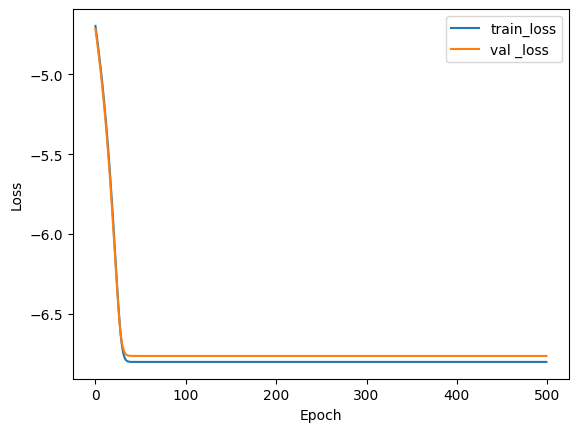

In [14]:
# Plot the results

plt.figure()

plt.plot(np.log10(H["train_loss"]), label="train_loss")
plt.plot(np.log10(H["val_loss"]), label="val _loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('Loss_curve_model_Cl_LR5e5_e1500.png')
plt.show()




In [ ]:
# After training
model.rbf.plot_distance_distribution()

In [ ]:
# Save the model if needed
save_path = './trained_models_Cl/{}_model_Cl_ESCNN_lr{}_e{}_rbf{}_convL{}.pth'.format(date, learning_rate, num_epochs, rbf_centres,num_convLayers)

torch.save(model.state_dict(), save_path)

In [ ]:
# joblib.dump(input_scaler, '../saved_scalers_cl/{}_ipScaler_lr{}_e{}_nrbf{}.pkl'.format(date, learning_rate, num_epochs, rbf_centres))
# joblib.dump(output_scaler, '../saved_scalers_cl/{}_opScaler_lr{}_e{}_nrbf{}.pkl'.format(date, learning_rate, num_epochs, rbf_centres))


## Evaluate the model

Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (0,)
Cds:  (0,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (0,)
Cds:  (0,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (47, 170)
Cds:  (47,)
Elements:  (0,)
Cds:  (0,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (0,)
Cds:  (0,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (45, 170)
Cds:  (45,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (48, 170)
Cds:  (48,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (49, 170)
Cds:  (49,)
Elements:  (44, 170)
Cds:  (44,)


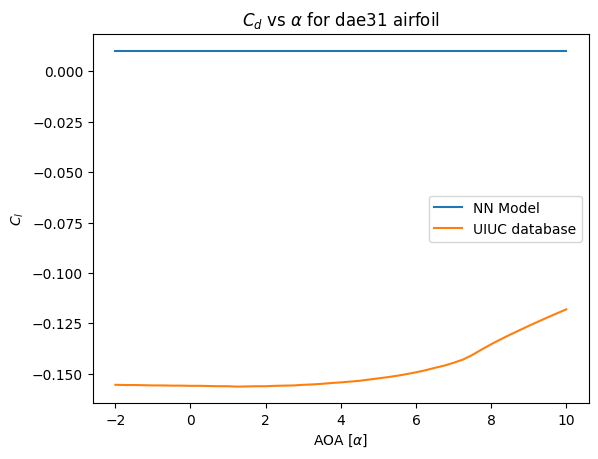

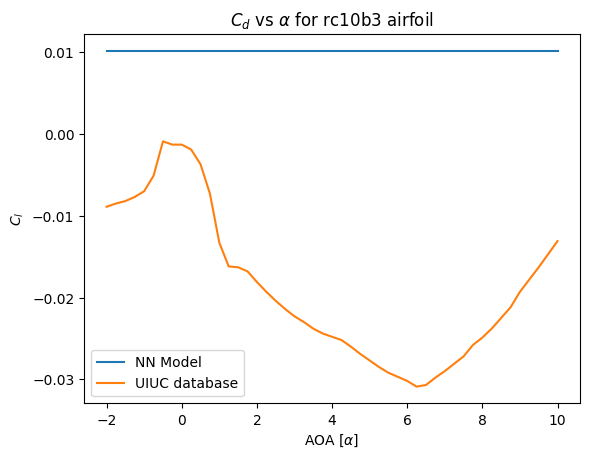

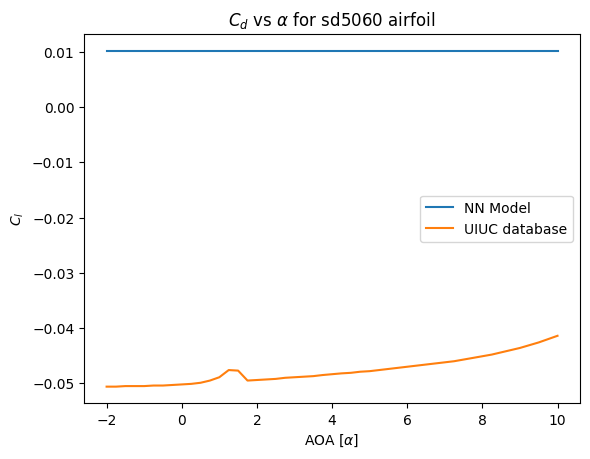

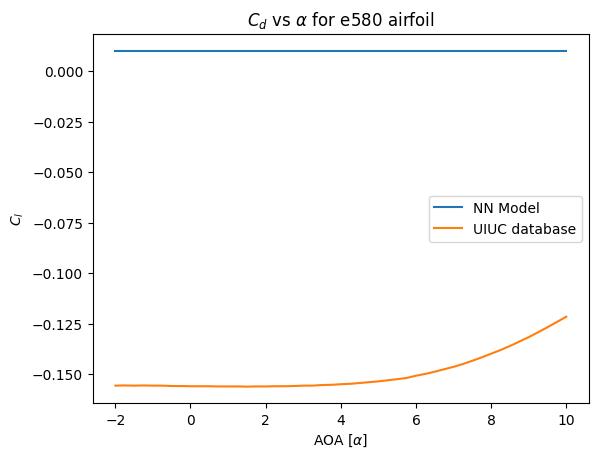

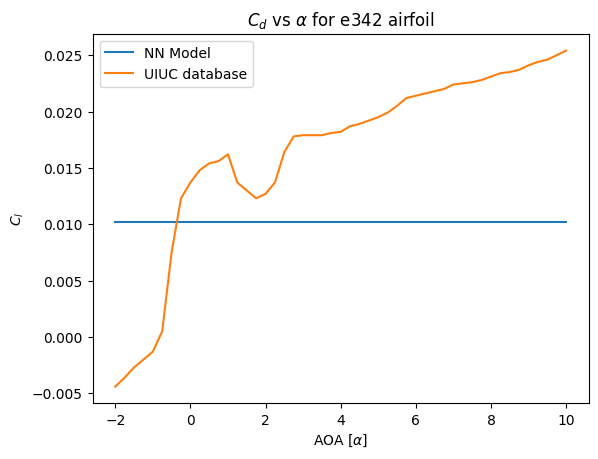

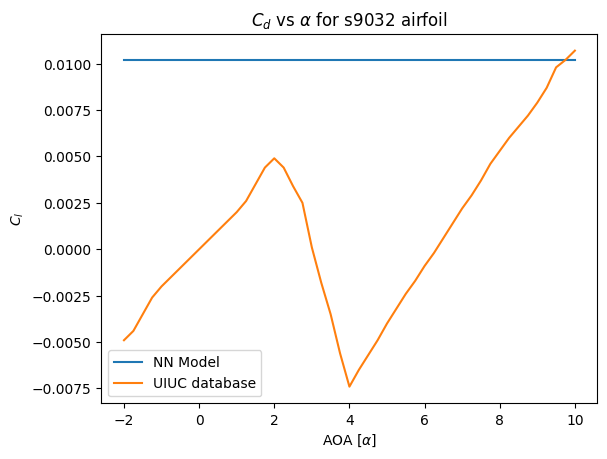

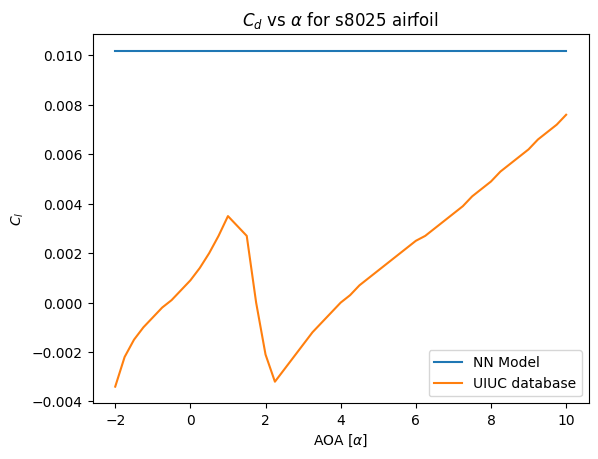

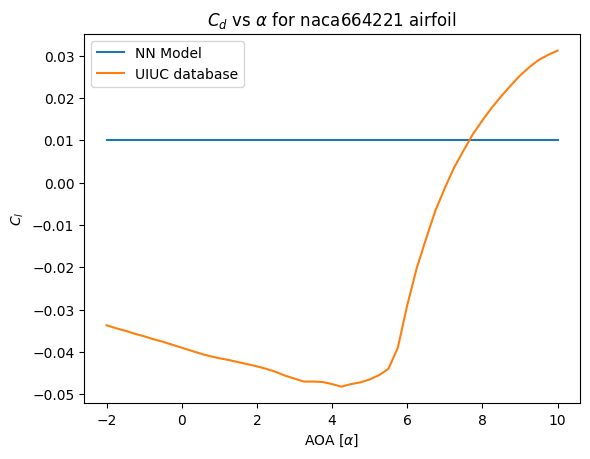

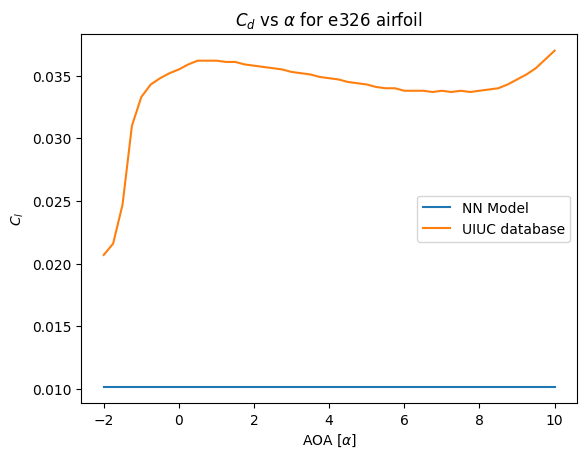

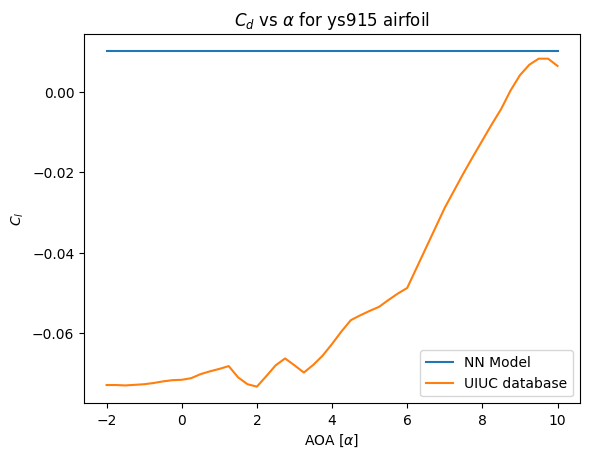

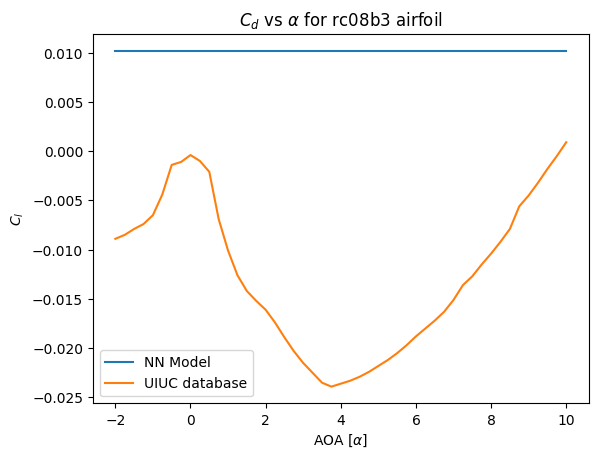

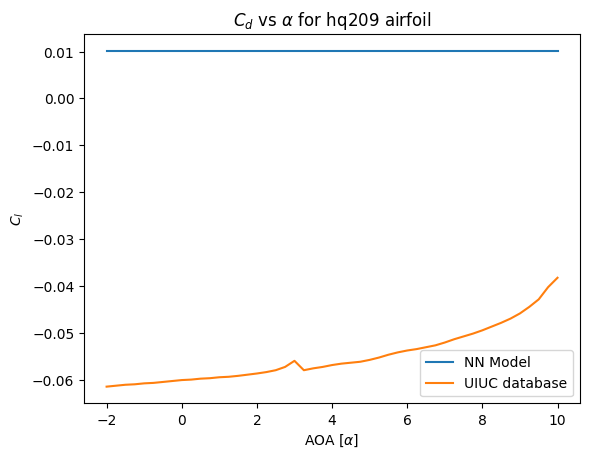

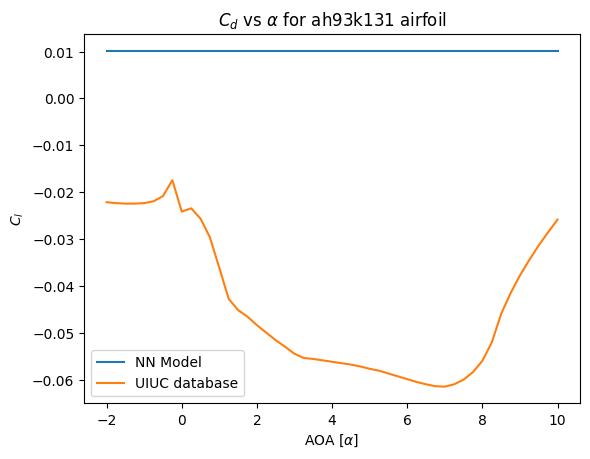

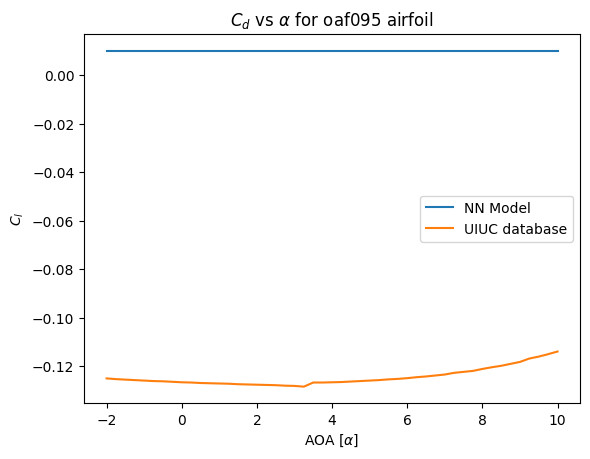

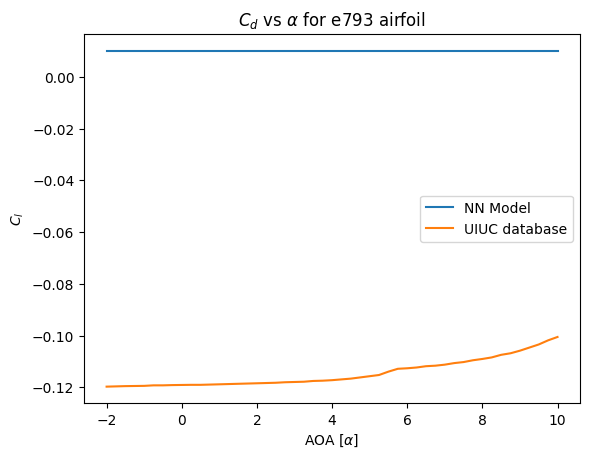

In [15]:
root_test = "small_database_testing_csv/"

coord_files = [f for f in os.listdir(root_test) if f.endswith('_coordinates.dat')]
coord_bases = {re.sub(r'\_coordinates.dat$', '', f) for f in coord_files}

for keyword in coord_bases:
    x_t, y_t, Cls_t, Cms_t, Cds_t, alphas_t = prep_data(root_test, keyword)
    Cls_t = np.array(Cls_t, dtype=float)
    Cds_t = np.array(Cds_t, dtype=float)
    # Cms_t = np.array(Cms_t, dtype=float)
    
    x_f_t = [] # Final coordinates - after downsizing
    y_f_t = []
    for num_airfoil in range(0, len(x_t)):
        downsampled_x = downsample_to_35(x_t[num_airfoil])
        downsampled_y = downsample_to_35(y_t[num_airfoil])

        x_f_t.append(downsampled_x)
        y_f_t.append(downsampled_y)
        
    Elements_t = organize_data(x_f_t, y_f_t, alphas_t)
    print("Elements: ",Elements_t.shape)
    print("Cds: ",Cls_t.shape)

    if Elements_t.shape != (0,):
        input_data_test = Elements_t

        # input_test_normalized = input_scaler.fit_transform(input_data_test)

        # Convert to PyTorch tensors
        # input_test = torch.tensor(input_test_normalized, dtype=torch.float32)
        input_test = torch.tensor(input_data_test, dtype=torch.float32)

        # Move data to GPU
        input_test = input_test.to(device)

        # Evaluate the model on test dataset
        with torch.no_grad():
            Cl_eval = model.forward(input_test)
            
        Cl_eval = Cl_eval.cpu().detach().numpy()  # Convert tensor to numpy array
        # Cl_eval_org_scale = output_scaler.inverse_transform(Cl_eval)

        plt.figure()
        plt.plot(alphas_t[0], Cl_eval)
        # plt.plot(alphas_t[0], Cl_eval_org_scale)
        plt.plot(alphas_t[0],Cds_t)

        plt.legend(['NN Model', 'UIUC database'])
        plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
        plt.xlabel(r'AOA [$\alpha$]')
        plt.ylabel(r'$C_l$')

    else:
        continue
